In [57]:
from datasets import load_dataset
from enum import Enum
from PIL import Image
import lancedb
from tqdm import tqdm
from IPython.display import display

dataset = load_dataset("CVdatasets/ImageNet15_animals_unbalanced_aug1", split="train")

class Animal(Enum):
    italian_greyhound = 0
    coyote = 1
    beagle = 2
    rottweiler = 3
    hyena = 4
    greater_swiss_mountain_dog = 5
    Triceratops = 6
    french_bulldog = 7
    red_wolf = 8
    egyption_cat = 9
    chihuahua = 10
    irish_terrier = 11
    tiger_cat = 12
    white_wolf = 13
    timber_wolf = 14

print(Animal(dataset[0]['labels']).name)

italian_greyhound


In [2]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
dataset[0]

{'labels': 0,
 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x339>,
 'is_generated': False}

In [4]:
def embed(img):
    image = preprocess(img).unsqueeze(0).to(device)
    embs = model.encode_image(image)
    return embs.detach().numpy()[0].tolist()

In [5]:
(embed(dataset[0]['img']))

[-0.37320834398269653,
 0.327055960893631,
 -0.04651312530040741,
 0.19801902770996094,
 -0.2640106976032257,
 0.11985310912132263,
 -0.01784827932715416,
 0.6432938575744629,
 -0.0012268167920410633,
 0.15160296857357025,
 -0.12470538169145584,
 -0.4123997986316681,
 -0.12672929465770721,
 -0.11381667107343674,
 0.6930686831474304,
 0.30221545696258545,
 0.634376585483551,
 0.4976358115673065,
 0.18956579267978668,
 -0.22609172761440277,
 -0.21728698909282684,
 0.1923295557498932,
 0.3102114498615265,
 -0.0966956689953804,
 -0.34052157402038574,
 -0.17714819312095642,
 0.2994213402271271,
 -0.03915920853614807,
 -0.2052377462387085,
 0.11400820314884186,
 0.4644746482372284,
 -0.10579101741313934,
 0.13155440986156464,
 -0.06114805489778519,
 0.05825602263212204,
 0.0031273679342120886,
 0.1451922059059143,
 0.584181547164917,
 -0.22512322664260864,
 0.8097527623176575,
 -0.4780838191509247,
 0.1122119352221489,
 0.5852934122085571,
 0.04073929041624069,
 0.2779013216495514,
 -0.08125

In [8]:
db = lancedb.connect('./data/tables')
tbl = db.create_table('animal_images', [{'vector': embed(dataset[0]['img']), 'id': 0, 'label': dataset[0]['labels']}])

data = []
for i in tqdm(range(1, len(dataset))):

    data.append({'vector': dataset[i]['img'], 'id': i, 'label': dataset[i]['labels']})

100%|██████████| 3704/3704 [00:13<00:00, 280.75it/s]


In [9]:
batched_data = [data[n:n+50] for n in range(0, len(data), 50)]

In [10]:
for i in tqdm(batched_data):
    batch_data = []
    for j in i:
        row = {}
        row['vector'] = embed(j['vector'])
        row['id'] = j['id']
        row['label'] = j['label']
        batch_data.append(row)
    tbl.add(batch_data)

100%|██████████| 75/75 [09:22<00:00,  7.50s/it]


In [5]:
db = lancedb.connect('./data/tables')
tbl = db.open_table('animal_images')

tbl.to_pandas()

vector    id  label
0     [-0.37320834, 0.32705596, -0.046513125, 0.1980...     0      0
1     [0.038414974, 0.07875503, -0.09304662, 0.45220...     1      0
2     [0.09422007, 0.03416324, -0.17524022, 0.659762...     2      0
3     [-0.22612132, 0.3696533, -0.1013299, 0.7694520...     3      0
4     [-0.21917152, 0.44102496, -0.057491355, 0.7005...     4      0
...                                                 ...   ...    ...
3700  [-0.26998034, -0.018881384, -0.069307424, 0.14...  3700     14
3701  [-0.35769746, -0.23190859, 0.101886846, 0.2030...  3701     14
3702  [0.006892047, -0.03980826, -0.0031479667, 0.28...  3702     14
3703  [-0.11250543, -0.20559089, -0.19839372, 0.2902...  3703     14
3704  [-0.21551852, -0.18505003, -0.15429664, 0.0846...  3704     14

[3705 rows x 3 columns]

In [8]:
test = load_dataset("CVdatasets/ImageNet15_animals_unbalanced_aug1", split="validation")

1439
{'labels': 0, 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x19D7C2DC910>, 'is_generated': False}
italian_greyhound


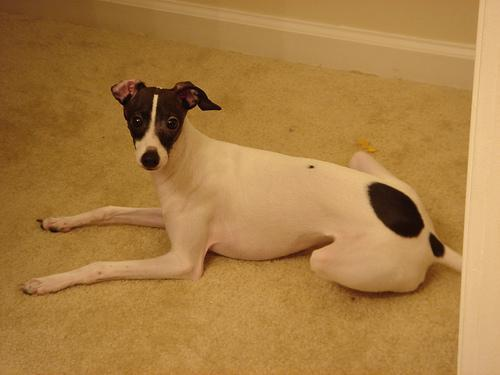

In [34]:
print(len(test))
print(test[0])
print(Animal(test[0]['labels']).name)
test[0]['img']

In [27]:
res = tbl.search(embed(test[0]['img'])).limit(1).to_df()
res

vector   id  label      score
0  [-0.24353579, -0.115527086, 0.053884186, 0.749...  120      0  24.568972

In [51]:
print(Animal(res['label'][0]).name)
id = int(res['id'][0])
id

italian_greyhound


120

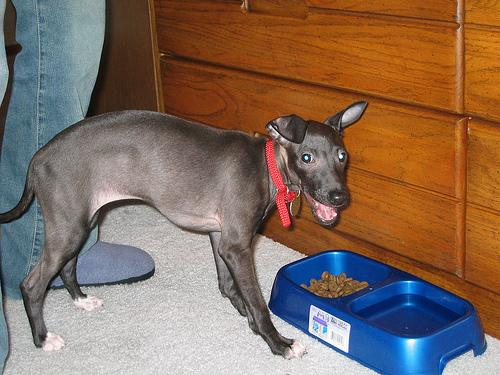

In [52]:
dataset[id]['img']

In [75]:
def image_search(id):
    print(Animal(test[id]['labels']).name)
    display(test[id]['img'])

    res = tbl.search(embed(test[id]['img'])).limit(5).to_df()
    print(res)
    for i in range(5):
        print(Animal(res['label'][i]).name)
        data_id = int(res['id'][i])
        display(dataset[data_id]['img'])

italian_greyhound


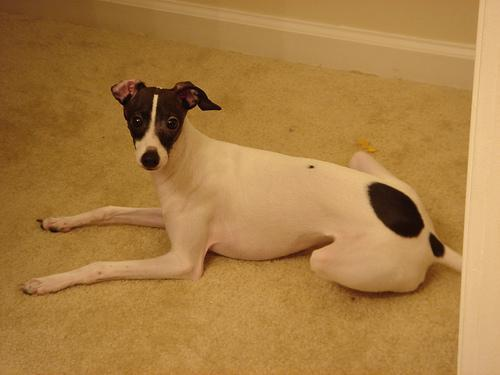

                                              vector   id  label      score
0  [-0.24353579, -0.115527086, 0.053884186, 0.749...  120      0  24.568972
1  [-0.18412282, -0.29097787, -0.3053207, 0.79688...  116      0  24.638737
2  [-0.10038204, -0.026646169, -0.029038692, 0.93...   56      0  25.126720
3  [0.0777705, -0.014915014, 0.06223715, 0.57464,...  162      0  25.546175
4  [0.08827609, 0.16788654, 0.0021198052, 0.27775...   52      0  27.176331
italian_greyhound


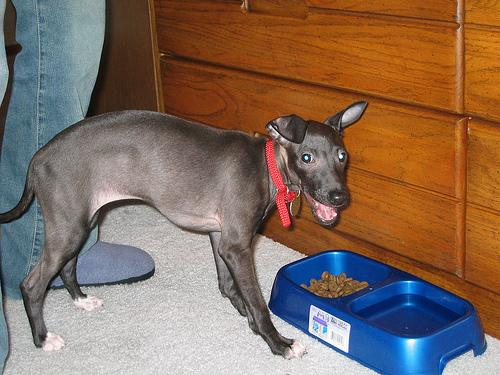

italian_greyhound


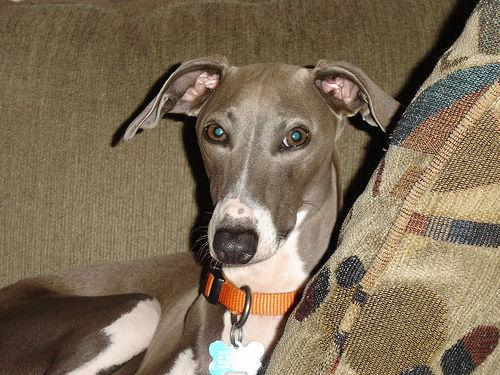

italian_greyhound


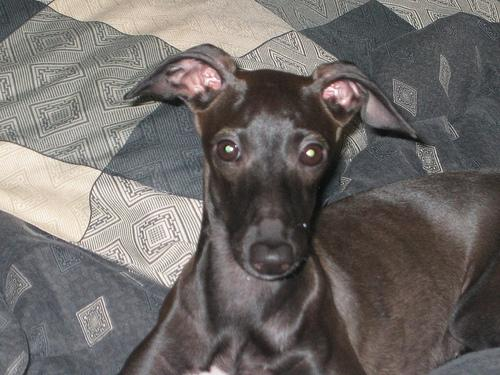

italian_greyhound


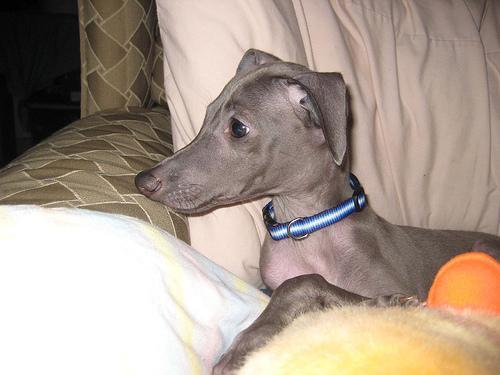

italian_greyhound


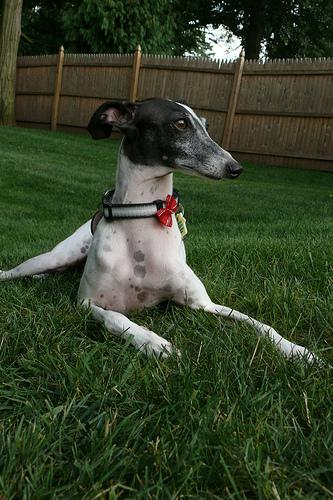

In [78]:
image_search(0)

beagle


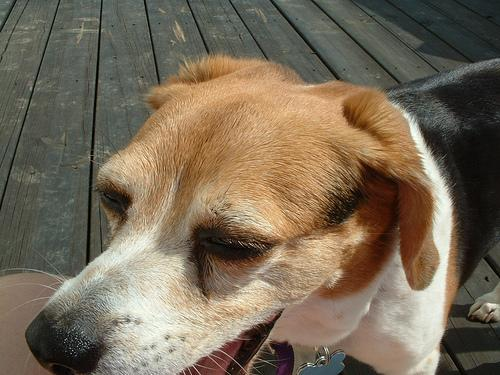

                                              vector   id  label      score
0  [0.12255902, 0.20735401, -0.07396008, 0.226123...  932      2  23.484886
1  [-0.23099507, -0.17685041, -0.05794196, 0.3080...  933      2  24.135656
2  [0.017519647, 0.015920304, 0.105266415, 0.3328...  808      2  24.582159
3  [0.119847864, 0.042861152, 0.022542017, 0.5360...  928      2  25.564110
4  [-0.31052402, 0.10011553, -0.2561085, 0.459805...  797      2  26.411701
beagle


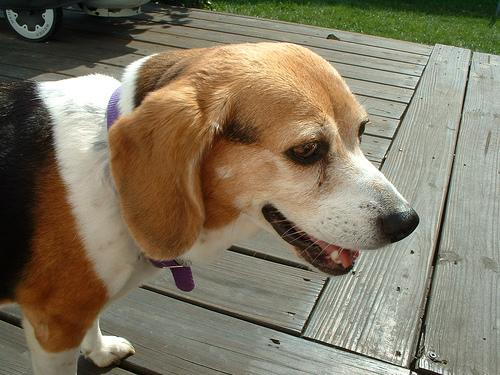

beagle


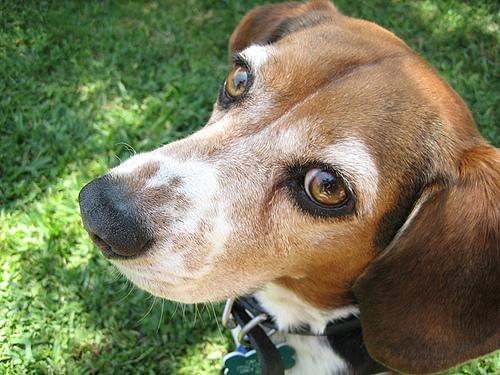

beagle


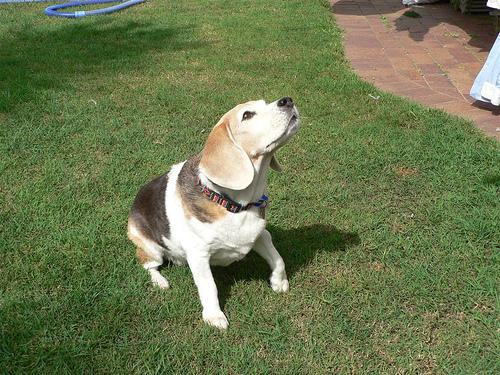

beagle


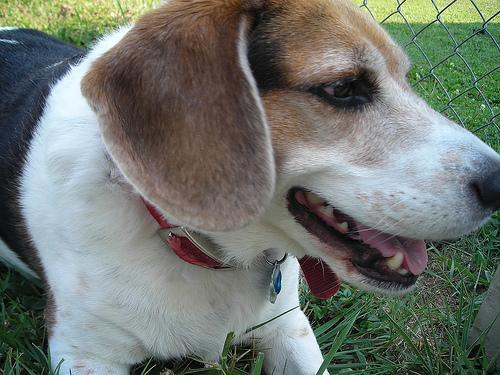

beagle


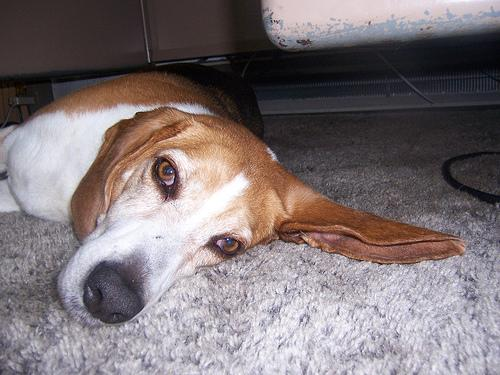

In [79]:
image_search(200)